In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import style

from pathlib import Path

from autumn.settings import INPUT_DATA_PATH


If not in an 'AuTuMN' python environment. Edit and run the cell below to manually create the path to files.

In [2]:
style.use("dark_background")
p = Path(".")
# INPUT_DATA_PATH = p.joinpath('c:\\', "Users","maba0001", "AuTuMN", "data", "inputs")

In [3]:

fb = p.joinpath(INPUT_DATA_PATH, "mobility", "movement-range-2021.txt")
gg = p.joinpath(INPUT_DATA_PATH, "mobility", "Google_Mobility_Report.csv")


REGIONS = ['Hanoi',"Ho Chi Minh City"]


In [4]:
fb_mob = pd.read_csv(fb, delimiter="\t")


C:\Users\Mili\Envs\summer\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
gg_mob = pd.read_csv(gg)

C:\Users\Mili\Envs\summer\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Get facebook mobility for country and regions of interest.

In [6]:
country = fb_mob["country"] == "VNM"
fb_mob = fb_mob[country]

fb_hcmc = fb_mob["polygon_id"].str.contains("VNM.25")
fb_hanoi = fb_mob["polygon_id"].str.contains("VNM.27")

fb_mob.loc[fb_hanoi, "polygon_name"] = "Hanoi"
fb_mob.loc[fb_hcmc, "polygon_name"] = "Ho Chi Minh City"

fb_mob = fb_mob[(fb_hcmc) | (fb_hanoi)]
fb_mob.rename(columns={'all_day_bing_tiles_visited_relative_change':'visited_tiles', 'all_day_ratio_single_tile_users':'single_tiles'}, inplace =True)
fb_mob = fb_mob[
    [
        "ds",
        "polygon_name",
        'visited_tiles',
        "single_tiles",
    ]
]
fb_mob["ds"] = pd.to_datetime(fb_mob["ds"], format="%Y-%m-%d")


For now take the mean. But ideally the weighted average based on population should be used.<br>
To implement this the population of each sub-region(VNM.25, VNM.27) is required.
 

In [7]:
fb_mob = fb_mob.groupby(['ds','polygon_name'], as_index=False).mean()

In [8]:
MOB_COL = [
    "workplaces",
    ]

GG_COLS = [
    "date",
    "sub_region_1",
    
] + MOB_COL

gg_hcmc = gg_mob["sub_region_1"].str.contains("Ho Chi Minh City")
gg_hanoi = gg_mob["sub_region_1"].str.contains("Hanoi")
gg_mob = gg_mob[(gg_hcmc) | (gg_hanoi)]
gg_mob.rename(columns=lambda x: str(x).replace("_percent_change_from_baseline",""),inplace=True)
gg_mob = gg_mob[GG_COLS]
gg_mob["date"] = pd.to_datetime(gg_mob["date"], format="%Y-%m-%d")


In [9]:
split_date = '2021-10-20'

In [10]:
df_mob = pd.merge(fb_mob, gg_mob,  how='left', left_on=['ds', 'polygon_name'], right_on=['date', 'sub_region_1'])
df_mob = df_mob[df_mob['ds'] >= '2021-01-01'] # For now, there is FB data for 2021.

In [11]:
df_mob.dropna(subset=['date'], inplace=True)
df_mob = df_mob[df_mob["polygon_name"].isin(REGIONS)]

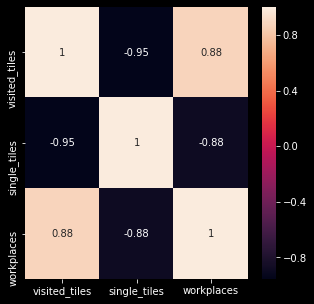

In [12]:
corr_plot = df_mob[['visited_tiles', 'single_tiles']+MOB_COL].corr()
plt.figure(figsize=(5,5))
hm = sns.heatmap(corr_plot, annot = True)

In [13]:
def get_xs(region, split_date, df):
    "Split the data set into test and train and add an intercept component"

    x_train = df[(df['polygon_name'] == region) & (df['ds'] < split_date)][['visited_tiles', 'single_tiles']].to_numpy()
    x_test = df[(df['polygon_name'] == region) & (df['ds'] >= split_date)][['visited_tiles', 'single_tiles']].to_numpy()
    x_train = sm.add_constant(x_train)
    x_test = sm.add_constant(x_test)

    return x_test, x_train

In [14]:
def get_train_y(region, split_date, df, y_col):

    y = df[(df['polygon_name'] == region) & (df['ds'] < split_date)][[y_col]].to_numpy()

    return y



In [15]:
df_mob[(df_mob["polygon_name"]=="Hanoi") & (df_mob["workplaces"].isna())]

,ds,polygon_name,visited_tiles,single_tiles,date,sub_region_1,workplaces
584,2021-10-20,Hanoi,-0.022861,0.218057,2021-10-20,Hanoi,NaN
586,2021-10-21,Hanoi,-0.049192,0.230392,2021-10-21,Hanoi,NaN
588,2021-10-22,Hanoi,-0.080790,0.233099,2021-10-22,Hanoi,NaN
590,2021-10-23,Hanoi,-0.064671,0.225586,2021-10-23,Hanoi,NaN
592,2021-10-24,Hanoi,-0.006733,0.230041,2021-10-24,Hanoi,NaN
594,2021-10-25,Hanoi,-0.047217,0.221842,2021-10-25,Hanoi,NaN
596,2021-10-26,Hanoi,-0.047326,0.231073,2021-10-26,Hanoi,NaN
598,2021-10-27,Hanoi,-0.058580,0.232586,2021-10-27,Hanoi,NaN
600,2021-10-28,Hanoi,-0.131803,0.273284,2021-10-28,Hanoi,NaN
602,2021-10-29,Hanoi,-0.191905,0.303698,2021-10-29,Hanoi,NaN


In [16]:
for region in REGIONS:

    x_test, x_train = get_xs(region,split_date, df_mob )

    for mobility_type in MOB_COL:
        
        y_train = get_train_y(region,split_date, df_mob, mobility_type )

        model = sm.OLS(y_train,x_train)
        results = model.fit()
        print(results.summary())

        y_pred = results.predict(x_test)


        df_mob.loc[(df_mob[mobility_type].isna()) & (df_mob['polygon_name']==region), mobility_type] = y_pred



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     350.9
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           4.72e-78
Time:                        10:55:57   Log-Likelihood:                -1207.6
No. Observations:                 292   AIC:                             2421.
Df Residuals:                     289   BIC:                             2432.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0502      6.069      0.997      0.3

In [17]:
df_mob.set_index(df_mob['ds'], inplace= True)

<AxesSubplot:xlabel='ds'>

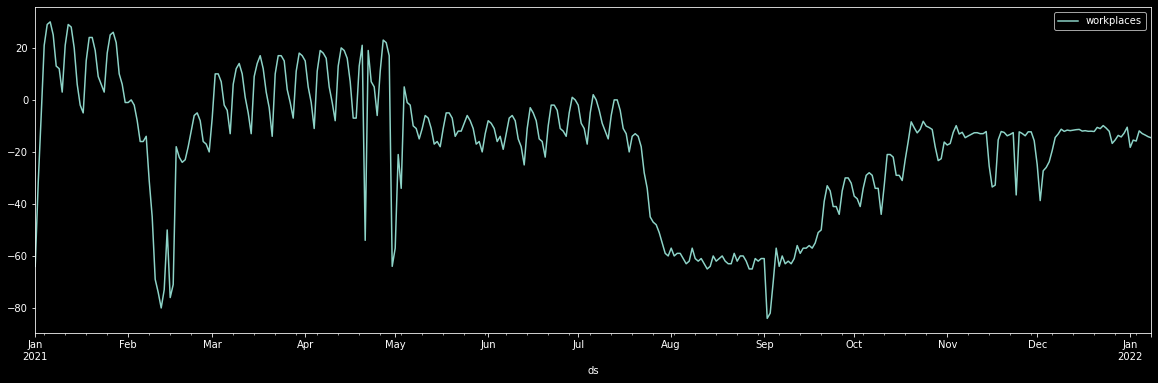

In [18]:
df_mob[df_mob['polygon_name'] == "Hanoi"][MOB_COL].plot(figsize=(20,6))

<AxesSubplot:xlabel='ds'>

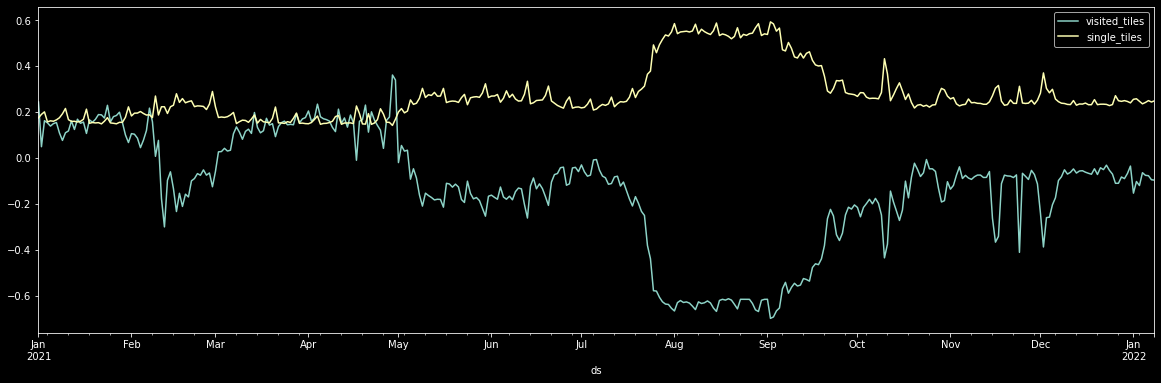

In [19]:
df_mob[df_mob['polygon_name'] == "Hanoi"][["visited_tiles","single_tiles"]].plot(figsize=(20,6))

<AxesSubplot:xlabel='ds'>

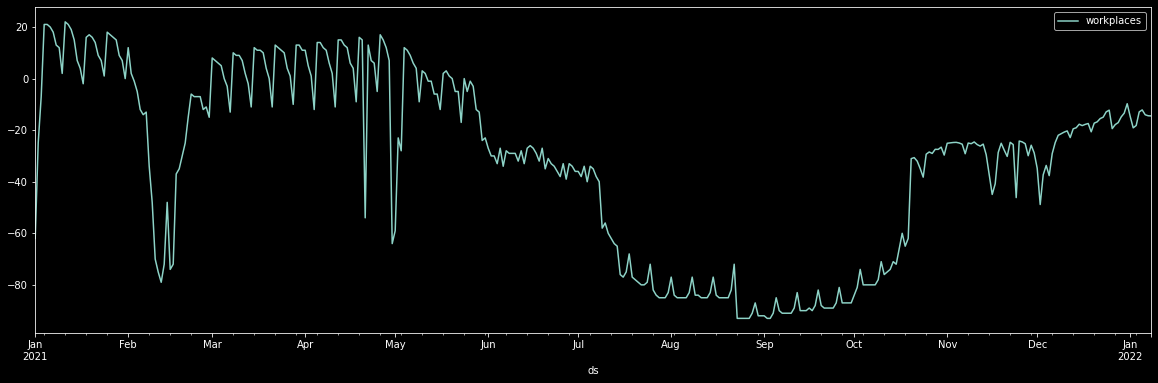

In [20]:
df_mob[df_mob['polygon_name'] == "Ho Chi Minh City"][MOB_COL].plot(figsize=(20,6))

<AxesSubplot:xlabel='ds'>

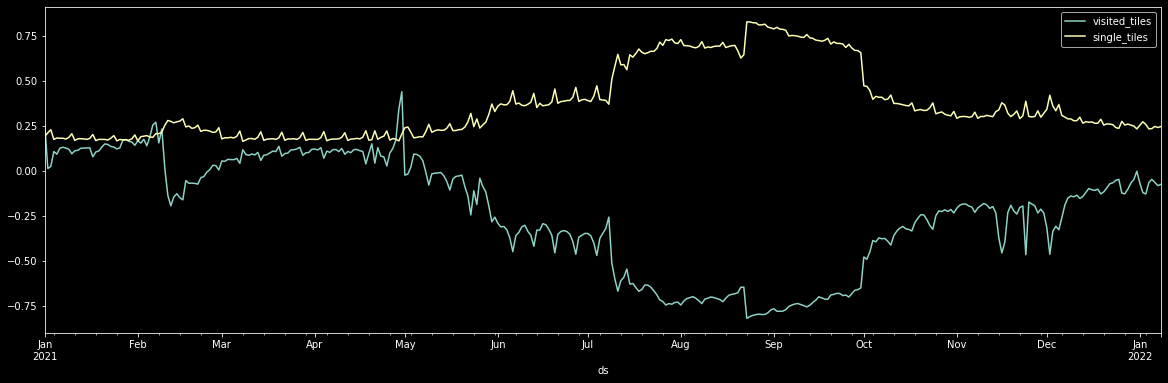

In [21]:
df_mob[df_mob['polygon_name'] == "Ho Chi Minh City"][["visited_tiles","single_tiles"]].plot(figsize=(20,6))

In [22]:
df_mob

,ds,polygon_name,visited_tiles,single_tiles,date,sub_region_1,workplaces
ds,,,,,,,
2021-01-01,2021-01-01,Hanoi,0.244208,0.174815,2021-01-01,Hanoi,-64.000000
2021-01-01,2021-01-01,Ho Chi Minh City,0.251342,0.191740,2021-01-01,Ho Chi Minh City,-62.000000
2021-01-02,2021-01-02,Hanoi,0.049211,0.190294,2021-01-02,Hanoi,-32.000000
2021-01-02,2021-01-02,Ho Chi Minh City,0.013675,0.212322,2021-01-02,Ho Chi Minh City,-25.000000
2021-01-03,2021-01-03,Hanoi,0.162702,0.201201,2021-01-03,Hanoi,-6.000000
2021-01-03,2021-01-03,Ho Chi Minh City,0.025675,0.229088,2021-01-03,Ho Chi Minh City,-7.000000
2021-01-04,2021-01-04,Hanoi,0.153271,0.157477,2021-01-04,Hanoi,21.000000
2021-01-04,2021-01-04,Ho Chi Minh City,0.108358,0.175333,2021-01-04,Ho Chi Minh City,21.000000
2021-01-05,2021-01-05,Hanoi,0.139110,0.162081,2021-01-05,Hanoi,29.000000


Create a csv for input db.

In [23]:
input_df = df_mob[df_mob['ds'] >= split_date][['ds', 'polygon_name']+MOB_COL]

In [24]:
input_df.rename(columns=lambda x:  f"{x}_percent_change_from_baseline" if x not in {'ds',"polygon_name"} else x,inplace=True)
input_df.rename(columns={'polygon_name':"sub_region_1", 'ds':"date"}, inplace = True)
input_df["country_region"] = "Vietnam"

In [25]:
vnm_csv = p.joinpath(INPUT_DATA_PATH, "mobility", "VNM_mobility.csv")

In [26]:
input_df.to_csv(vnm_csv, index=False)